I compare `redrock` failures for $\sim 5000$ DESI-like GAMA-Legacy 
synthetic spectra. We run `redrock` with three different settings: 

1. `redrock` no flags
2. `redrock` with archetype flag

~~3. `redrock` with archetype flag where the archetypes were constructed with strong H$\alpha$ spectra added to the training set.~~
3. `redrock` with archetype flag (updated 9/25/2018) and updated redrock template 

In [1]:
import h5py 
import numpy as np 
from astropy.io import fits
from desispec.io import read_spectra
from desispec.io import write_spectra
# -- feasibgs -- 
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
# read in GAMA-Legacy catalog
cata = Cat.GamaLegacy()
gleg = cata.Read('g15')

In [4]:
# select properties from the GAMA-Legacy catalog
redshift = gleg['gama-spec']['z']
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha_flux']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]
ngal = len(redshift)
print('%i galaxies total' % ngal)

63495 galaxies total


In [5]:
dir_spec = UT.dat_dir()+'spectra/gamadr3_legacydr7/'
#f_spec = ''.join([dir_spec, 'g15.synSpectra.darksky.seed1.exptime300.1of13blocks.fits'])
#spec = read_spectra(f_spec)

In [6]:
# read in gleg data
fblock = h5py.File(dir_spec+'gleg.g15.darksky.seed1.exptime300.1of13blocks.hdf5', 'r')
block = {}
for g in fblock.keys():
    block[g] = {} 
    for k in fblock[g].keys(): 
        block[g][k] = fblock[g][k].value
        
magnorm_flag = block['forwardmodel']['magnorm_flag']

# read in redrock output (w/ no archetype)
zblock1 = fits.open(dir_spec+'g15.synSpectra.darksky.seed1.exptime300.1of13blocks.redrock.fits')[1].data
# read in redrock output (w/ archetype)
zblock2 = fits.open(dir_spec+'g15.synSpectra.darksky.seed1.exptime300.1of13blocks.redrock.archetype.fits')[1].data
# read in redrock output (w/ archetype updated and updated template)
zblock3 = fits.open(dir_spec+'g15.synSpectra.darksky.seed1.exptime300.1of13blocks.redrock.uparch.uptemp.fits')[1].data

## read in redrock output (w/ updated archetype constructed using GLeg synthetic spectra)
#zblock3 = fits.open(dir_spec+'g15.synSpectra.darksky.seed1.exptime300.1of13blocks.redrock.uparchetype.fits')[1].data

In [7]:
def zfail(z_rr, z_true, zwarn): 
    dz_1pz = np.abs(z_true - z_rr)/(1.+z_true)
    return (dz_1pz > 0.003) & (zwarn == 0) & magnorm_flag

In [8]:
z_true = block['gama-spec']['z']

fail_block1, fail_block2, fail_block3 = {}, {}, {} 

for i, zb, fb in zip([1, 2, 3], [zblock1, zblock2, zblock3], [fail_block1, fail_block2, fail_block3]): 
    fail = zfail(zb['Z'], z_true, zb['ZWARN'])
    
    for g in block.keys(): 
        fb[g] = {}
        for k in block[g].keys():
            fb[g][k] = block[g][k][fail]
    print('redrock w/ criteria %i fails for %i out of %i targets' % (i, np.sum(fail), np.sum(magnorm_flag)))

redrock w/ criteria 1 fails for 105 out of 4972 targets
redrock w/ criteria 2 fails for 90 out of 4972 targets
redrock w/ criteria 3 fails for 89 out of 4972 targets


In [45]:
failblocks = [fail_block1, fail_block2, fail_block3]
lbls = [r'RR criterion $\#$1', r'RR criterion $\#$2', r'RR criterion $\#$3']
colors = ['C0', 'C1', 'C3']

Text(0.5,1,'redrock redshift failures')

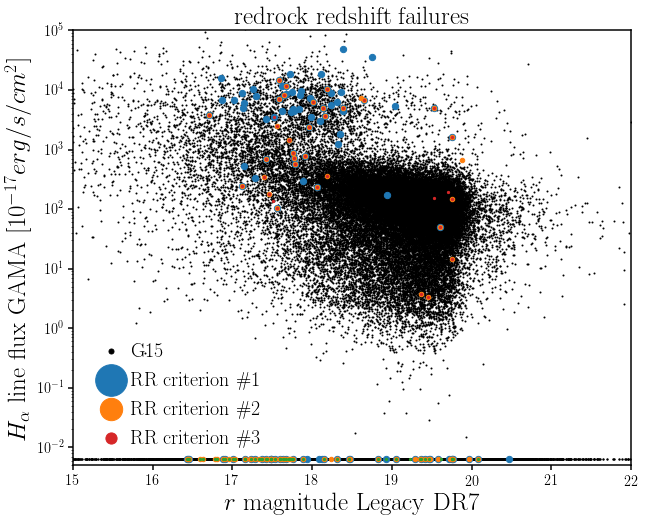

In [46]:
fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(111)
# entire G15 field
hasha = (gama_ha > 0)
sub.scatter(r_mag_legacy[hasha], gama_ha[hasha], s=1, c='k', label='G15')
sub.scatter(r_mag_legacy[~hasha], np.repeat(10**-2.2, np.sum(~hasha)), s=2, c='k')

sizes = [40, 20, 5]
for i_f, failblock in enumerate(failblocks): 
    fail_ha = failblock['gama-spec']['ha_flux']
    fail_r_mag = UT.flux2mag(failblock['legacy-photo']['flux_r'])

    hasha = (fail_ha > 0.)
    sub.scatter(fail_r_mag[hasha], fail_ha[hasha], s=sizes[i_f], c=colors[i_f], label=lbls[i_f])
    sub.scatter(fail_r_mag[~hasha], np.repeat(10**-2.2, np.sum(~hasha)), s=sizes[i_f], c='C'+str(i_f))
    sub.legend(loc='lower left', markerscale=5, handletextpad=0., fontsize=20)
sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=25)
sub.set_xlim([15., 22.])
sub.set_ylabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=25)
sub.set_ylim([5e-3, 1e5])
sub.set_yscale('log')
sub.set_title("redrock redshift failures", fontsize=25)

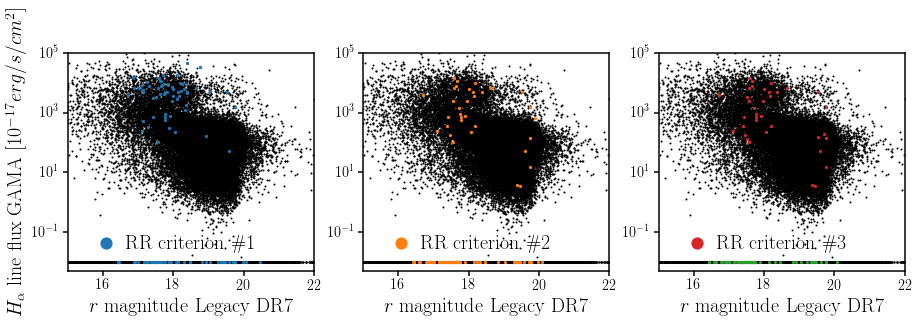

In [47]:
fig = plt.figure(figsize=(15,4))
for i_f, failblock in enumerate(failblocks):
    sub = fig.add_subplot(1,3,1+i_f)
    # entire G15 field
    hasha = (gama_ha > 0)
    sub.scatter(r_mag_legacy[hasha], gama_ha[hasha], s=1, c='k')
    sub.scatter(r_mag_legacy[~hasha], np.repeat(1e-2, np.sum(~hasha)), s=2, c='k')

    fail_ha = failblock['gama-spec']['ha_flux']
    fail_r_mag = UT.flux2mag(failblock['legacy-photo']['flux_r'])

    hasha = (fail_ha > 0.)
    sub.scatter(fail_r_mag[hasha], fail_ha[hasha], s=5, c=colors[i_f], label=lbls[i_f])
    sub.scatter(fail_r_mag[~hasha], np.repeat(1e-2, np.sum(~hasha)), s=5, c='C'+str(i_f))
    sub.legend(loc='lower left', markerscale=5, handletextpad=0., fontsize=20)
    sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
    sub.set_xlim([15., 22.])
    if i_f == 0: sub.set_ylabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
    sub.set_ylim([5e-3, 1e5])
    sub.set_yscale('log')

(15.0, 22.0)

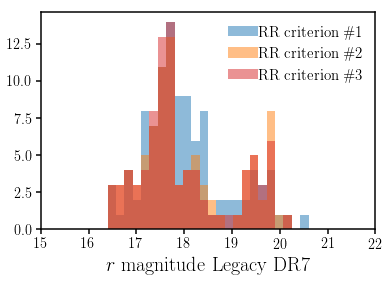

In [48]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i_f, failblock in enumerate(failblocks):
    fail_r_mag = UT.flux2mag(failblock['legacy-photo']['flux_r'])
    _ = sub.hist(fail_r_mag, range=(15, 22), bins=40, color=colors[i_f], alpha=0.5, label=lbls[i_f])
sub.legend(loc='upper right', handletextpad=0., fontsize=15)
sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.])

(0.0, 5.0)

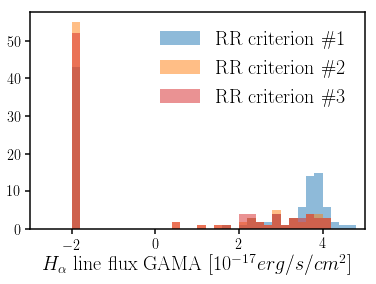

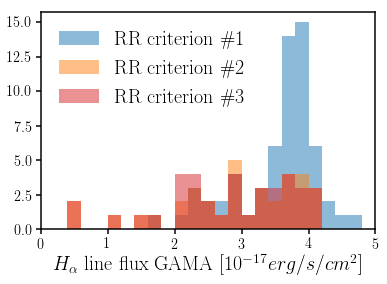

In [49]:
fig = plt.figure()
sub = fig.add_subplot(111)

for i_f, failblock in enumerate(failblocks): 
    fail_ha = failblock['gama-spec']['ha_flux']
    hasha = (fail_ha > 0.)
    fail_has = fail_ha.copy()
    fail_has[~hasha] = 1e-2
    _ = sub.hist(np.log10(fail_has), range=(-3, 5), bins=40, color=colors[i_f], alpha=0.5, label=lbls[i_f])
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_xlim([-3., 5.])

fig = plt.figure()
sub = fig.add_subplot(111)
for i_f, failblock in enumerate(failblocks): 
    fail_ha = failblock['gama-spec']['ha_flux']
    hasha = (fail_ha > 0.)
    _ = sub.hist(np.log10(fail_ha[hasha]), range=(-3, 5), bins=40, color=colors[i_f], alpha=0.5, label=lbls[i_f])
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_xlim([0., 5.])